In [ ]:
pip install protobuf==3.20.*

In [51]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import tensorflow as tf
from sklearn.metrics import f1_score 
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Dropout, Conv2D

Haar cascade is used for object detection.
It first trains from a lot of positive(target obj present) and negative images(images without target obj present).
It is then used to detect objects in other images. 

In [52]:
# Loads the data required for detecting the license plates from cascade classifier.
plate_cascade = cv2.CascadeClassifier('C:/Users/KIIT/Desktop/plate detection/indian_license_plate.xml')
#It is a machine learning based approach where a cascade function is trained from a lot of positive and negative images. It is then used to detect objects in other images.

# Forming a rectangle around the number plate

In [121]:

def detect_plate(img, text=''): # the function detects and performs blurring on the number plate.
    plate_img = img.copy()
    
    # detects numberplates and returns the coordinates and dimensions of detected license plate's contours.
    plate_rect = plate_cascade.detectMultiScale(plate_img, scaleFactor = 1.1, minNeighbors = 7)
    #detectMultiScale----your model has a fixed size defined during training, which is visible in the XML. This means that this size of the plate is detected in the image if present.
    #by rescaling the input image, you can resize a larger plate to a smaller one, making it detectable by the algorithm.
    
    for (x,y,w,h) in plate_rect:
        #based on these four factors rectangle will be drawn
        # extracting the Region of Interest(roi) of license plate for blurring - where license plate is located
       
        #plate = plate_img[y-5:y+h+5, x-7:x+w+3] #coordinates of plate[length,breadth]
        #print(plate)

        #cv2.rectangle(plate_img, (x-3,y), (x+w, y+h), (51,181,155), 3)
        
        plate = plate_img[y:y+h, x:x+w, :]
        cv2.rectangle(plate_img, (x+2,y), (x+w-3, y+h-5), (51,181,155), 3)
        # representing the detected contours(shapes) by drawing rectangles around the edges.
        #forms a rectangle with parameters(image size, point1(top-left),point2(right-bottom),colour,thickness)
        
        
        #cv2.putText() method is used to draw a text string on any image.
        #SYNTAX:
        #cv2.putText(image, text, coordinates of bottom-left corner of the string(x & y cordinates), font type , fontScale, BGR, thickness of line, lineType=cv2.LINE_AA , bottomLeftOrigin(optional- bool))
        
        
        if text!='':
            plate_img = cv2.putText(plate_img, text, (x,y-20), cv2.FONT_HERSHEY_COMPLEX_SMALL , 2, (51,181,155), 1, cv2.LINE_AA)
            
        
    return plate_img,plate # returning the processed image.

In [122]:
# Testing the above function
def display(image, title=''):
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # cv2.cvtColor() method is used to convert an image from one color space to another
    #Syntax: cv2.cvtColor(src, code to convert [cv2.COLOR_...])
    #src-image
    
    
    
    #plotting the graph
    fig = plt.figure(figsize=(10,6))
    ax = plt.subplot(111)
    ax.imshow(img)
    plt.axis('off')
    plt.title(title)
    plt.show()


# Input Image

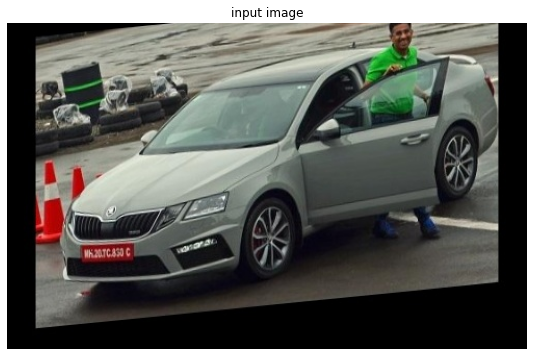

In [123]:
img= cv2.imread('./Indian Number Plates Images/Indian Number Plates Images/shearYPos_pad_licensed_car2.jpeg')

#showing the input image
display(img, 'input image')

In [124]:
# Getting plate from the processed image
output_img, plate = detect_plate(img)

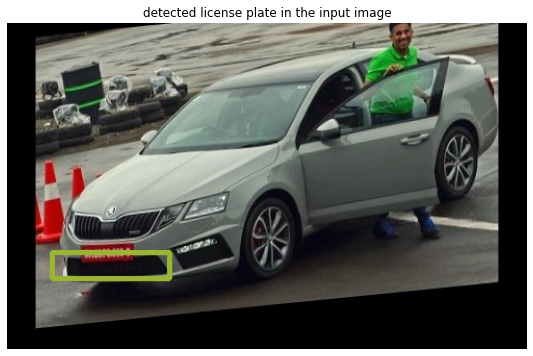

In [125]:
display(output_img, 'detected license plate in the input image')  #using the display function

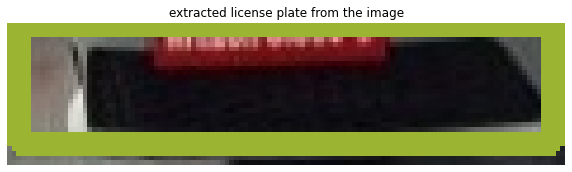

In [126]:
display(plate, 'extracted license plate from the image')

In [9]:
#Contours can be explained simply as a curve joining all the continuous points (along the boundary), having the same color or intensity.
# Match contours to license plate or character template

def find_contours(dimensions, img) :

    # Find all contours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    
    # Check largest 5 or  15 contours for license plate or character respectively
    #leaving out the noise(small countours)
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    
    ii = cv2.imread('contour.jpg')
    
    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        # detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        # checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) #stores the x coordinate of the character's contour, to used later for indexing the contours

            char_copy = np.zeros((44,24))
            # extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))
            
            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            plt.imshow(ii, cmap='gray')

            # Make result formatted for classification: invert colors
            char = cv2.subtract(255, char)

            # Resize the image to 24x44 with black border from resized char(20,40)
            #adding 4pixels extra for x and y, our required area is [2:42, 2:22]
            
            char_copy[2:42, 2:22] = char
            
            #0=black (making borders black on both sides 2 px each) 
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy) # List that stores the character's binary image (unsorted)
            
    # Return characters on ascending order with respect to the x-coordinate (most-left character first)
    plt.title('contours found')
    plt.show()
    
    # arbitrary function that stores sorted list of character indices
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])# stores character images according to their index
    img_res = np.array(img_res_copy)  #forms an array

    return img_res

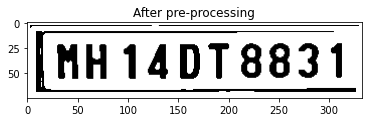

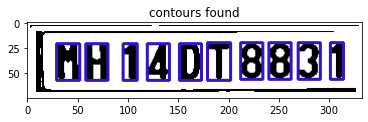

In [10]:
# Find characters in the resulting images
def segment_characters(image) :

    # Preprocess cropped license plate image
    img_lp = cv2.resize(image, (333, 75))    #resize
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)    #grayscaling
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)   #threshold--converts the grey scaled image to a binary image
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))    #erode--removing unwanted pixels from the object’s boundary (removing boundary noise)
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))    #dilation-- to fill up the absent pixels meaning pixels that should have a value of 1 but are having value 0.

    #img_binary_lp has (rows,columns)
    LP_WIDTH = img_binary_lp.shape[0]  #contains rows value
    LP_HEIGHT = img_binary_lp.shape[1]  #contains columns value

    # Make borders white--- to remove any out of the frame pixel in case it is present.
    #making 3pixels border on each side, img size is[333,75]
    img_binary_lp[0:3 , :] = 255
    img_binary_lp[: , 0:3] = 255
    img_binary_lp[72:75 , :] = 255
    img_binary_lp[: , 330:333] = 255

    # Estimations of character contours sizes of cropped license plates
    #to the character’s dimensions with this value for filtering out the required characters.
    dimensions = [LP_WIDTH/6, LP_WIDTH/2, LP_HEIGHT/10, 2*LP_HEIGHT/3]
    
    plt.imshow(img_binary_lp, cmap='gray')
    plt.title('After pre-processing')
    plt.show()
    cv2.imwrite('contour.jpg',img_binary_lp)

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_binary_lp)

    return char_list
# Let's see the segmented characters
char = segment_characters(plate)


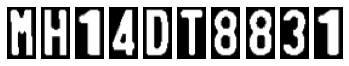

In [13]:
#most number plates(indian number plates) have 10 digits
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(char[i], cmap='gray')
    plt.axis('off')
    
#in some plates it shows error this is because some have lesser value than 10 values 

# MODEL FOR CHARACTERS
for modeling, we will be using a Convolutional Neural Network with 3 layers.

ImageDataGenerator class available in keras to generate some more data using image augmentation techniques like width shift, height shift

Width shift: Accepts a float value denoting by what fraction the image will be shifted left and right.

Height shift: Accepts a float value denoting by what fraction the image will be shifted up and down.

In [16]:
import tensorflow.keras.backend as K
train_datagen = ImageDataGenerator(rescale=1./255, width_shift_range=0.1, height_shift_range=0.1)
path = './data/data'
train_generator = train_datagen.flow_from_directory( path+'/train',  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28
        batch_size=1,  class_mode='sparse')

validation_generator = train_datagen.flow_from_directory( path+'/val',  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28
        batch_size=1, class_mode='sparse')


Found 864 images belonging to 36 classes.
Found 216 images belonging to 36 classes.


In [17]:
# Metrics for checking the model performance while training
def f1score(y, y_pred):
    return f1_score(y, tf.math.argmax(y_pred, axis=1), average='micro') 

def custom_f1score(y, y_pred):
    return tf.py_function(f1score, (y, y_pred), tf.double)

In [18]:
K.clear_session()
model = Sequential()
#model.add(Conv2D(16, (22,22), input_shape=(28, 28, 3), activation='relu', padding='same')) #convolutional layer with 16 output filters, a convolution window of size (22,22), and ‘Relu’ as activation function.
model.add(Conv2D(32, (16,16), input_shape=(28, 28, 3), activation='relu', padding='same'))
#model.add(Conv2D(64, (8,8), input_shape=(28, 28, 3), activation='relu', padding='same'))
#model.add(Conv2D(64, (4,4), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(4, 4))) #The objective is to down-sample an input representation 
model.add(Dropout(0.4)) #Dropout is a regularization hyperparameter initialized to prevent Neural Networks from Overfitting.
model.add(Flatten()) #The flatten layer takes data from the previous layer and represents it in a single dimension.
model.add(Dense(128, activation='relu'))
model.add(Dense(36, activation='softmax'))

#Adding 2 dense layers, one with the dimensionality of the output space as 128, activation function=’relu’
#final layer with 36 outputs for categorizing the 26 alphabets (A-Z) + 10 digits (0–9) and activation function=’ softmax’

model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=0.0001), metrics=[custom_f1score])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        24608     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 7, 7, 32)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 7, 7, 32)          0         
                                                                 
 flatten (Flatten)           (None, 1568)              0         
                                                                 
 dense (Dense)               (None, 128)               200832    
                                                                 
 dense_1 (Dense)             (None, 36)                4644      
                                                        

In [20]:
class stop_training_callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_custom_f1score') > 0.99):
            self.model.stop_training = True

In [21]:
batch_size = 1
callbacks = [stop_training_callback()]
model.fit(
      train_generator,
      steps_per_epoch = train_generator.samples // batch_size,
      validation_data = validation_generator, 
      epochs = 80, verbose=1, callbacks=callbacks)

Epoch 1/80
864/864 [==============================] - 31s 16ms/step - loss: 3.2154 - custom_f1score: 0.1609 - val_loss: 2.3582 - val_custom_f1score: 0.3472
Epoch 2/80
864/864 [==============================] - 10s 12ms/step - loss: 1.6411 - custom_f1score: 0.5475 - val_loss: 0.9813 - val_custom_f1score: 0.7731
Epoch 3/80
864/864 [==============================] - 10s 12ms/step - loss: 0.9030 - custom_f1score: 0.7269 - val_loss: 0.5798 - val_custom_f1score: 0.8241
Epoch 4/80
864/864 [==============================] - 11s 12ms/step - loss: 0.6086 - custom_f1score: 0.8067 - val_loss: 0.3877 - val_custom_f1score: 0.9028
Epoch 5/80
864/864 [==============================] - 10s 12ms/step - loss: 0.4637 - custom_f1score: 0.8542 - val_loss: 0.2829 - val_custom_f1score: 0.9259
Epoch 6/80
864/864 [==============================] - 10s 12ms/step - loss: 0.4042 - custom_f1score: 0.8785 - val_loss: 0.2731 - val_custom_f1score: 0.9120
Epoch 7/80
864/864 [==============================] - 10s 11ms/s

In [40]:
from tensorflow import keras
from keras.models import save_model

model.save('C:/Users/KIIT/Desktop/plate detection/plate_detection_model',save_format="h5")

# testing the model

In [23]:
# Predicting the output
def fix_dimension(img): 
    new_img = np.zeros((28,28,3))
    for i in range(3):
        new_img[:,:,i] = img
    return new_img
  
def show_results():
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i,c in enumerate(characters):
        dic[i] = c

    output = []
    for i,ch in enumerate(char): #iterating over the characters
        img_ = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
        img = fix_dimension(img_)
        img = img.reshape(1,28,28,3) #preparing image for the model
        y_ =np.argmax(model.predict(img)[0]) #to predict
        character = dic[y_] 
        output.append(character) #storing the result in a list
        
    plate_number = ''.join(output)
    
    return plate_number

print(show_results())


1/1 [==============================] - 0s 18ms/step
HH140T8831


1/1 [==============================] - 0s 35ms/step


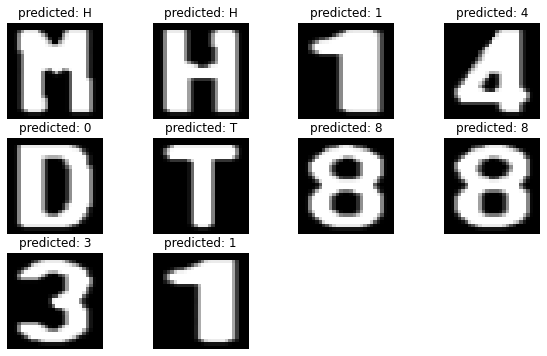

In [24]:
# Segmented characters and their predicted value.
plt.figure(figsize=(10,6))
for i,ch in enumerate(char):
    img = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
    plt.subplot(3,4,i+1)
    plt.imshow(img,cmap='gray')
    plt.title(f'predicted: {show_results()[i]}')
    plt.axis('off')
plt.show()

In [34]:
plate_number = show_results()
print(plate_number)




1/1 [==============================] - 0s 36ms/step
HH140T8831


In [41]:
def custom_print(message_to_print, log_file='C:/Users/KIIT/Desktop/plate detection/plate_numbers.txt'):
    print(message_to_print)
    with open(log_file, 'a') as of:
        of.write(message_to_print + '\n')

In [42]:
custom_print(plate_number)

HH140T8831


In [127]:
output_img, plate = detect_plate(img, plate_number)
#display(output_img, 'detected license plate number in the input image')

NameError: name 'plate_number' is not defined